# CNN on Griddified MNIST

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='1'

import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

### Load and flatten data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

# load
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# flatten
x_train_flatten = x_train.reshape(x_train.shape[0], -1)
x_test_flatten = x_test.reshape(x_test.shape[0], -1)

### Do Griddify on train and test sets

In [3]:
from griddify import Griddify
import pickle
from pathlib import Path

path_train = Path("../../files/MNIST/Xi_train.pkl")
path_test = Path("../../files/MNIST/Xi_test.pkl")

if path_train.is_file() and path_test.is_file():
    'If it exists, we load it.'
    with open(path_train, "rb") as f:
        Xi_train = pickle.load(f)
    with open(path_test, "rb") as f:
        Xi_test = pickle.load(f)
else:
    'Otherwise, we compute it and save it to disk.'
    gf = Griddify(preprocess=False)
    gf.fit(x_train_flatten)
    Xi_train = gf.transform(x_train_flatten)
    Xi_test = gf.transform(x_test_flatten)
    
    with open(path_train, "wb+") as f:
        pickle.dump(Xi_train, f, pickle.HIGHEST_PROTOCOL)
    with open(path_test, "wb+") as f:
        pickle.dump(Xi_test, f, pickle.HIGHEST_PROTOCOL)    

### Preprocessing

In [4]:
# Scale images to the [0, 1] range
Xi_train = Xi_train.astype("float32") / 255
Xi_test = Xi_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
Xi_train = np.expand_dims(Xi_train, -1)
Xi_test = np.expand_dims(Xi_test, -1)

print("Xi_train shape:", Xi_train.shape)
print(Xi_train.shape[0], "train samples")
print(Xi_test.shape[0], "test samples")

Xi_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


### Model

In [5]:
'Model parameters'
num_classes = 10
input_shape = (28, 28, 1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
'Build model'
from tensorflow.keras import layers

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

### Train model

In [7]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [8]:
model.fit(Xi_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 4s 72us/sample - loss: 0.4058 - accuracy: 0.8754 - val_loss: 0.1022 - val_accuracy: 0.9728
Epoch 2/15
54000/54000 [==============================] - 2s 45us/sample - loss: 0.1409 - accuracy: 0.9571 - val_loss: 0.0684 - val_accuracy: 0.9820
Epoch 3/15
54000/54000 [==============================] - 2s 46us/sample - loss: 0.1092 - accuracy: 0.9659 - val_loss: 0.0563 - val_accuracy: 0.9853
Epoch 4/15
54000/54000 [==============================] - 2s 46us/sample - loss: 0.0920 - accuracy: 0.9711 - val_loss: 0.0514 - val_accuracy: 0.9855
Epoch 5/15
54000/54000 [==============================] - 2s 46us/sample - loss: 0.0824 - accuracy: 0.9747 - val_loss: 0.0475 - val_accuracy: 0.9872
Epoch 6/15
54000/54000 [==============================] - 2s 43us/sample - loss: 0.0752 - accuracy: 0.9760 - val_loss: 0.0427 - val_accuracy: 0.9890
Epoch 7/15
54000/54000 [==============================] -

<AxesSubplot:title={'center':'Performance Learning Curve'}>

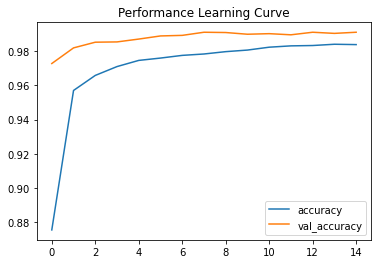

In [9]:
pd.DataFrame(model.history.history)[['accuracy', 'val_accuracy']].plot(title="Performance Learning Curve")

<AxesSubplot:title={'center':'Optimization Learning Curve'}>

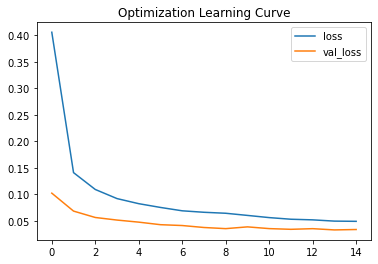

In [10]:
pd.DataFrame(model.history.history)[['loss', 'val_loss']].plot(title="Optimization Learning Curve")

### Evaluation on test set: Loss and Accuracy

In [11]:
score_griddify = model.evaluate(Xi_test, y_test, verbose=0)

print("Test loss:", score_griddify[0])
print("Test accuracy:", score_griddify[1])

Test loss: 0.03508820873153163
Test accuracy: 0.9885


-----

# Performance comparison between the original MNIST and the Griddified one

### Preprocess, fit and predict the original MNIST dataset

Preprocessing

In [12]:
# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Fitting

In [13]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/15
54000/54000 [==============================] - 2s 46us/sample - loss: 0.4187 - accuracy: 0.8917 - val_loss: 0.0783 - val_accuracy: 0.9768
Epoch 2/15
54000/54000 [==============================] - 2s 46us/sample - loss: 0.1374 - accuracy: 0.9593 - val_loss: 0.0596 - val_accuracy: 0.9838
Epoch 3/15
54000/54000 [==============================] - 2s 46us/sample - loss: 0.1096 - accuracy: 0.9665 - val_loss: 0.0496 - val_accuracy: 0.9857
Epoch 4/15
54000/54000 [==============================] - 2s 46us/sample - loss: 0.0970 - accuracy: 0.9702 - val_loss: 0.0437 - val_accuracy: 0.9885
Epoch 5/15
54000/54000 [==============================] - 2s 46us/sample - loss: 0.0869 - accuracy: 0.9728 - val_loss: 0.0424 - val_accuracy: 0.9890
Epoch 6/15
54000/54000 [==============================] - 2s 46us/sample - loss: 0.0788 - accuracy: 0.9757 - val_loss: 0.0398 - val_accuracy: 0.9885
Epoch 7/15
54000/54000 [==============================] -

Predicting

In [14]:
score_original = model.evaluate(x_test, y_test, verbose=0)

print("Test loss:", score_original[0])
print("Test accuracy:", score_original[1])

Test loss: 0.027741805064224172
Test accuracy: 0.9902


### Comparison of test accuracies

In [15]:
print("Accuracy of the original MNIST:", score_original[1])
print("Accuracy of the Griddified MNIST:", score_griddify[1])
print("Difference:", round(abs(score_original[1] - score_griddify[1]), 3))

Accuracy of the original MNIST: 0.9902
Accuracy of the Griddified MNIST: 0.9885
Difference: 0.002
